# 画像生成 AI 入門: Python による拡散モデルの理論と実践

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/shunk031/coloso-python-diffusion-models/blob/main/lectures/section-06-18.ipynb)

## Section 06. Latent Diffusion and Stable Diffusion

Latent Diffusion Model (LDM) は Stable Diffusion の元となる拡散モデルで、これまでの拡散モデルと比べて計算量が少なく広く一般的に使用されるようになりました。

本セクションでは LDM や Stable Diffusion の概要、またこれらのモデルに含まれる重要なコンポーネントについて実際に diffusers を使って動作を確認していきます。

### Lecture 18. Components of Stable Diffusion

テキストから高画質な画像を生成可能な Stable Diffusion は最先端の技術を含む複数のコンポーネントから構成されています。以下、diffusers をベースにそれぞれのコンポーネントの動作原理について説明していきます。

## セットアップ

### GPU が使用できるか確認

本 Colab ノートブックを実行するために GPU ランタイムを使用していることを確認します。CPU ランタイムと比べて画像生成がより早くなります。以下の `nvidia-smi` コマンドが失敗する場合は再度講義資料の `GPU 使用設定` のスライド説明や Google Colab の [FAQ](https://research.google.com/colaboratory/faq.html#gpu-utilization) 等を参考にランタイムタイプが正しく変更されているか確認してください。

In [ ]:
!nvidia-smi

Sun Jun 25 02:15:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 利用する Python ライブラリをインストール

diffusers ライブラリをインストールすることで拡散モデルを簡単に使用できるようにします。diffusers ライブラリを動かす上で必要となるライブラリも追加でインストールします:
  - [transformers](https://github.com/huggingface/transformers): 拡散モデルにおいて核となる Transformer モデルが定義されているライブラリ
  - [accelerate](https://github.com/huggingface/accelerate): transformers と連携してより高速な画像生成をサポートするライブラリ

In [ ]:
!pip install diffusers==0.16.1
!pip install transformers accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Stable Diffusion のコンポーネントについて

Stable Diffusion は、[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752) で提案された Latent Diffusion Model (LDM) という特殊なタイプの拡散モデルに基づいています。

LDM は、実際のピクセル空間を使用する代わりに、低次元の潜在空間上で拡散過程を計算することにより、メモリと計算の複雑さを軽減することができます。これが標準的な拡散モデルと LDM の主な違いです。LDM では、モデルは画像の潜在（圧縮）表現を生成するように訓練されます。

LDM は以下の3つの主要なコンポーネントから構成されています:
- Variational Auto-Encoder (VAE)
- U-Net
- Text encoder (CLIP text encoder)

### VAE [`[Kingma+ ICLR'14]`](https://arxiv.org/abs/1312.6114) について

VAE には、エンコーダー (encoder) とデコーダー (decoder) から構成されています。エンコーダーは、画像を低次元の潜在表現に変換し、U-Net の入力として使用します。デコーダは、逆に潜在表現を画像に変換します。

LDM の学習では、エンコーダは、各ステップで少しずつノイズを付与していく拡散過程 (forward diffusion process) のために、画像の潜在表現 (latent data) を得るために使用されます。推論では、逆拡散過程 (reverse diffusion process) で生成された潜在データを、デコーダで画像に戻します。後述するように、推論時に必要なのはVAEデコーダだけです。

### U-Net [`[Ronneberger+ MICCAI'15]`](https://arxiv.org/abs/1505.04597) について

U-Netは、ResNet ブロックで構成されたエンコーダ部とデコーダ部から構成されています。エンコーダは画像表現を低解像度画像表現に圧縮 (encode) し、デコーダは低解像度画像表現をノイズの少ない元の高解像度画像表現に復号 (decode) します。より具体的に U-Net はノイズ画像からノイズ部分を予測します。これは最終的にノイズ画像から画像を生成する際に利用されます。

U-Netがダウンサンプリング中に重要な情報を失うのを防ぐため、通常、エンコーダのダウンサンプリング ResNet とデコーダのアップサンプリング ResNet の間にショートカットの接続 (skip connection, residual connection などと呼ばれる) が追加されます。さらに、Stable Diffusion の U-Net は、cross attention 層を介して、CLIP text encoder によるテキストベクトルの基づく条件付けが可能です。Cross attention 層は、U-Net のエンコーダ部とデコーダ部の両方に、通常 ResNet ブロックの間に追加されます。

### Text Encoder (CLIP Text Encoder [`[Radford+ ICML'21]`](https://arxiv.org/abs/2103.00020)) について

テキストエンコーダは、例えば `"An astronout riding a horse"` のような入力プロンプトを、U-Net が理解できるベクトルに変換する役割を担っています。これは通常、入力トークン列を潜在的なテキストベクトルの列にマッピングするのみに利用されます。

Stable Diffusion は Imagen [[Saharia+ NeurIPS'22]](https://arxiv.org/abs/2205.11487) を参考にしており、学習中に CLIP text encoder を学習せず、単に事前学習済みモデルとして使用します。

### なぜ LDM は高速で効率的なのか？

LDM の U-Net は低次元空間で動作するため、ピクセル空間の拡散モデルと比較してメモリや計算量を大幅に削減することができます。例えば、Stable Diffusionで使用される Auto-Encoder は、縮小率が8であり、これは、形状が `(3, 512, 512)` の画像が潜在空間では `(3, 64, 64)` となります。これは LDM のように入力として潜在データではなく画像として扱ってしまうと`8 ✕ 8 = 64` 倍のメモリを必要とすることを意味しています。

これが、16 GB GPU RAM を有する Colab でも、`512 ✕ 512` の画像を高速に生成できる理由です 🤗

### Stable Diffusion の推論

それでは、推論時のモデルの動きを、論理的な流れで詳しく見ていきましょう。

Stable Diffusion は、潜在的な seed と text prompt の両方を入力として受け取ります。潜在的な seed を元に、ランダムなノイズを元にした `64 ✕ 64` サイズのノイズ画像を生成します。
 一方、text prompt は CLIP の text encoder によって、`77 ✕ 768` サイズのテキストベクトルに変換されます。

次に、U-Net は、テキストベクトルを条件として、ノイズ画像から繰り返しノイズ除去します。U-Net の出力は生成が期待される綺麗な画像と現在のノイズ画像との差分です。この出力はスケジューラアルゴリズムによってノイズ除去された潜在表現を計算するために使用されます。この計算には多くの異なるスケジューラアルゴリズムを使用することができ、それぞれに長所と短所があります。Stable Diffusionでは、以下のいずれかを使用することが推奨されています:

- [PNDM スケジューラー](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
   - デフォルトで使用されています
- [K-LMS スケジューラー](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)
- [Heun Discrete スケジューラー](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py)
- [DPM Solver Multistep スケジューラー](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py)
  - このスケジューラーは、より少ないステップで優れた品質を実現することができます。デフォルトの50ではなく、25で試すことができます 🤗

スケジューラアルゴリズムの機能に関する理論は、このノートブックの範囲外ですが、要するに、以前のノイズ表現と予測ノイズの残差から、予測ノイズ除去画像表現を計算することを覚えておくとよいでしょう。詳しくは、「[拡散に基づく生成モデルの設計空間の解明 - Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)」を参照してください。

このノイズ除去処理を約 50 回繰り返すことで、より良い潜在表現を段階的に取得することができます。潜在表現が完成すると、VAE のデコーダ部によって復号され、生成画像を得ることができます。

## Diffusers を元に Stable Diffusion のコンポーネントの関わり合いを確認する

このセクションでは [Karras+ NeurIPS'22](https://arxiv.org/abs/2206.00364) の [K-LMS スケジューラー](https://huggingface.co/docs/diffusers/api/schedulers/lms_discrete) と呼ばれる一般的に使用されるものとは少し異なるスケジューラを利用して Stable Diffusion を使う方法を紹介します。

まず、関係する個々のモデルやコンポーネントを読み込むことから始めます。GPU を使用するように指定し、読み込むモデルとして `runwayml/stable-diffusion-v1-5` を指定しました。

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

sd_model_id = "runwayml/stable-diffusion-v1-5"
clip_model_id = "openai/clip-vit-large-patch14"

学習済み Stable Diffusion には、以下のフォルダ名・ディレクトリ名でそれぞれ学習済みコンポーネントが格納されています:

- `text_encoder`: Stable Diffusion は CLIP を使用していますが、他の拡散モデルではBERT など他のエンコーダを使用することがあります
- `tokenizer`: `text_encoder` モデルで使用されているものと一致する必要があります
- `scheduler`: 学習中に画像にノイズを徐々に追加するために使用されるスケジューリングアルゴリズムです
- `unet`: 入力の潜在的な表現を生成するために使用されるモデルです
- `vae`: 潜在表現を実画像にデコードするために使用する auto-encoder モデルです

各コンポーネントに定義されている `from_pretrained` 関数の `subfolder` 引数を用いて、保存されたフォルダを参照することで、対象のコンポーネントを読み込むことができます。

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# VAE と U-Net は Stable Diffusion の事前学習済みモデルから読み込む
vae = AutoencoderKL.from_pretrained(sd_model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(sd_model_id, subfolder="unet")

# CLIP は openai/clip-vit-large-patch14 から読み込む
# Stable Diffusion 学習時には CLIP は freeze されているため
# もともとの重みを読み込むことでも動作が可能
tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)
text_encoder = CLIPTextModel.from_pretrained(clip_model_id)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.21.mlp.fc2.bias', 'vision_model.encoder.layers.3.self_attn.out_proj.bias', 'vision_model.encoder.layers.11.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.19.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.12.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.mlp.fc2.weight', 'vision_model.embeddings.position_ids', 'vision_model.encoder.layers.12.self_attn.q_proj.bias', 'vision_model.encoder.layers.15.self_attn.k_proj.bias', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.mlp.fc2.weight', 'vision_model.encoder.layers.13.mlp.fc2.bias', 'vision_model.encoder.layers.5.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.self_attn.k_proj.weight', 'vision_model.encoder.layers.2

今度は、あらかじめ用意されたスケジューラーを読み込むのではなく、K-LMS　のスケジューラーを使うことにします。

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler.from_pretrained(sd_model_id, subfolder="scheduler")

次に、読み込んだコンポーネントをGPUに移動させます。

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

画像生成に使用するパラメータを定義します。

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

height = 512 # 生成画像の高さ
width = 512  # 生成画像の幅

num_inference_steps = 50 # ノイズ除去のステップ数; デフォルト値を使用

guidance_scale = 7.5 # classifier-free guidance の guidance scale

generator = torch.manual_seed(32)   # seed を生成する generator

batch_size = 1

`guidance_scale` は、[Imagen の論文](https://arxiv.org/abs/2205.11487) の式 (2) のガイダンス重み `w` に類似して定義されていることに注意してください。`guidance_scale == 1` は、分類器不使用誘導 (classifier-free guidance) を行うことに相当します。ここでは、前回と同様に 7.5 に設定しています。

まず、プロンプトのテキストベクトルを `text_embeddings` (embeddings: 埋め込み; ある低次元空間への写像を "埋め込む" と読んだりするために、埋め込みと呼ばれることが多いです) として取得します。これらのベクトルは U-Net モデルの条件付けに使われます。

In [ ]:
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():
    outputs = text_encoder(text_input.input_ids.to(torch_device))
    text_embeddings = outputs.last_hidden_state

print(text_embeddings.size())

torch.Size([1, 77, 768])


Classifier-free guidance のための条件なしテキストベクトルを取得します。実際は padding token (空テキスト) に対するベクトルのみになります。これらは、条件付き `text_embeddings` (`batch_size x seq_length`) と同じサイズである必要があります。

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    outputs = text_encoder(uncond_input.input_ids.to(torch_device))
    uncond_embeddings = outputs.last_hidden_state

print(uncond_embeddings.size())

torch.Size([1, 77, 768])


Classifier-free guidance のために、2回 `text_encoder` に入力する必要があります。1 つは条件付きベクトル (`text_embeddings`)、もう 1 つは条件なしベクトル (`uncond_embeddings`) です。実際は 2 回の入力を避けるために両者を 1 つのバッチに連結して入力する方法がとられます。

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

print(text_embeddings.size())

torch.Size([2, 77, 768])


画像生成のために、初期の状態となるランダムノイズを生成します。

In [ ]:
latents = torch.randn(
  (batch_size, unet.config.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

latents.shape

torch.Size([1, 4, 64, 64])

サイズが `64 x 64` の潜在データが生成されることが期待されます。モデルはこの潜在データ (初期は純粋なノイズ) を、逆拡散過程と VAE のデコードを経て `512 x 512` の画像として変換していきます。

次に、選択した `num_inference_steps` でスケジューラーを初期化します。これにより、ノイズ除去処理中に使用される σ と正確なステップ数が計算されます。

In [ ]:
scheduler.set_timesteps(num_inference_steps)

K-LMS スケジューラは、潜在データに σ を掛ける合わせる必要があるため、以下のように計算しておきます。

In [ ]:
latents = latents * scheduler.init_noise_sigma

ノイズ除去のループを計算する準備が整いました。以下のようにして段階的にノイズを除去していきましょう。

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):

    # Classifier-free guidance で 2 回 のモデル forward 計算を避けるために、潜在データを 2 つににしてバッチ化します
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # U-Net を元にノイズ残差を予測します
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Classifier-free guidance を適用します
    # - 計算されたノイズ残差に対して、無条件ベクトルとテキスト条件付きベクトルに分割
    # - 分割されたそれぞれを用いて classifier-free guidance を計算
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # 現在のステップ x_t から前のステップ x_{t-1} を予測
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/50 [00:00<?, ?it/s]

生成された潜在データを画像に戻すためのデコードに `vae` を使用します。

In [ ]:
# 適切なスケーリングを行った後に、VAE でデコードを行う
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

最後に、画像を簡単に表示したり保存したりできるように、PIL 形式に変換します。

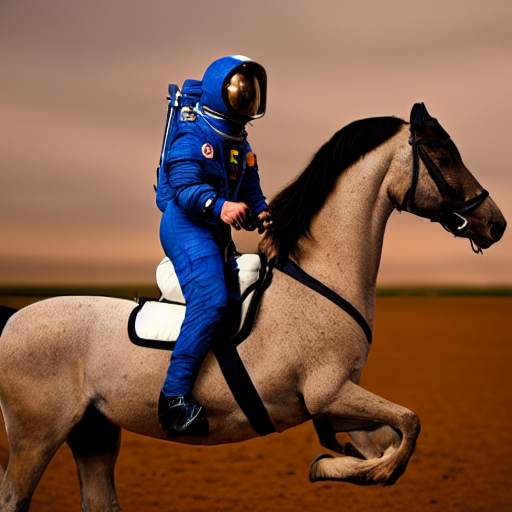

In [ ]:
from PIL import Image

image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

以上のようにして Stable Diffusion を構成する各要素を使用して自身の好きなようにカスタマイズできる手順を一通り体験していただきました。